In [1]:
import numpy as np
import pandas as pd
from hepunits import constants as c
from hepunits import units as u
from matplotlib import colors
from matplotlib import pyplot as plt
from scipy.integrate import quad

In [2]:
# Element properties
elements = ["Be", "C", "Si", "Ge"]
attenuation_coefficients = {}
photon_energies = set()
for e in elements:
    df = pd.read_csv(
        f"{e}_transparency.txt", sep="\s+"
    )  # [E] = MeV, [mu/rho] = cm^2 / g, https://physics.nist.gov/PhysRefData/XrayMassCoef/tab3.html

    def interpol(E, df=df):
        return np.interp(E / u.MeV, df["E"], df["mu/rho"]) * u.cm**2 / u.g

    attenuation_coefficients[e] = interpol
    photon_energies.update(df["E"] * u.MeV)
photon_energies = np.array(sorted(photon_energies))
#photon_energies = np.logspace(-3, 1, 100) * u.MeV
transfered_momenta = np.linspace(0, 20, 100) * (c.h_Planck / (2 * u.angstrom))
molar_masses = {
    "Be": 9.0 * u.g / u.mol,
    "C": 12.0 * u.g / u.mol,
    "Si": 28.0 * u.g / u.mol,
    "Ge": 73.0 * u.g / u.mol,
}
mass_numbers = {
    "Be": 9,
    "C": 12,
    "Si": 28,
    "Ge": 73,
}
densities = {
    "Be": 1.9 * u.g / u.cm**3,
    "C": 3.5 * u.g / u.cm**3,
    "Si": 2.3 * u.g / u.cm**3,
    "Ge": 5.3 * u.g / u.cm**3,
}
debye_temperatures = {  # @ room temperature https://www.knowledgedoor.com/2/elements_handbook/debye_temperature.html
    "Be": 1031.0 * u.kelvin,
    "C": 1550.0 * u.kelvin,
    "Si": 692.0 * u.kelvin,
    "Ge": 403.0 * u.kelvin,
}
lattice_vectors = {
    "Be": (
        np.array((1.0, 0.0, 0.0)) * 228.60 * u.pico * u.m,
        np.array((-np.cos(60 * u.deg), np.sin(60 * u.deg), 0.0))
        * 228.60
        * u.pico
        * u.m,
        np.array((0.0, 0.0, 1.0)) * 358.42 * u.pico * u.m,
    ),
    "C": (
        np.array((1.0, 0.0, 0.0)) * 3.567 * u.angstrom,
        np.array((0.0, 1.0, 0.0)) * 3.567 * u.angstrom,
        np.array((0.0, 0.0, 1.0)) * 3.567 * u.angstrom,
    ),
}
reciprocal_lattice_vectors = {}
for e, (a1, a2, a3) in lattice_vectors.items():
    vol = np.dot(a1, np.cross(a2, a3))
    b1 = c.two_pi * np.cross(a2, a3) / vol
    b2 = c.two_pi * np.cross(a3, a1) / vol
    b3 = c.two_pi * np.cross(a1, a2) / vol
    reciprocal_lattice_vectors[e] = (b1, b2, b3)


def sf_be(h, k, l):
    if l % 2:  # l odd
        if (h + 2 * k) % 3:  # (h + 2k) = 3N +- 1
            return np.sqrt(3)
        else:  # (h + 2k) = 3N
            return 0.0
    else:  # l even
        if (h + 2 * k) % 3:  # (h + 2k) = 3N +- 1
            return 1.0
        else:  # (h + 2k) = 3N
            return 2.0


def sf_diamond(h, k, l):
    if not ((h + k + l) % 4):  # h + k + l = 4N
        return 8
    if not ((h + k + l - 1) % 2):  # h + k + l = 2N + 1
        return np.sqrt(32.0)
    if not ((h + k + l - 2) % 4):  # h + k + l = 4N + 2
        return np.sqrt(0.0)


structure_factors = {
    "Be": sf_be,
    "C": sf_diamond,
}

cell_occupancies = {
    "Be": 2,
    "C": 8,
}

In [3]:
print((c.h_Planck / a3[2]) / (u.keV / c.c_light))
b3 * c.hbar / (u.keV / c.c_light)
for e, (b1, b2, b3) in reciprocal_lattice_vectors.items():
    print(e)
    print(b1 * c.hbar / (u.keV / c.c_light))
    print(b2 * c.hbar / (u.keV / c.c_light))
    print(b3 * c.hbar / (u.keV / c.c_light))

3.4758676319932778
Be
[ 5.42363073  3.13133466 -0.        ]
[0.         6.26266932 0.        ]
[ 0.        -0.         3.4591875]
C
[3.47586763 0.         0.        ]
[0.         3.47586763 0.        ]
[0.         0.         3.47586763]


In [4]:
# Average photon free path
free_paths = {}
for e in elements:

    def free_path_fun(E, att=attenuation_coefficients[e], den=densities[e]):
        return 1.0 / (att(E) * den)

    free_paths[e] = free_path_fun

In [5]:
# Coherent nucleon number
coherent_nucleons = {}
for e in elements:

    def coh_fun(
        E,
        free_path=free_paths[e],
        density=densities[e],
        molar_mass=molar_masses[e],
        mass_number=mass_numbers[e],
    ):
        return free_path(E) ** 3 * density / molar_mass * c.Avogadro * mass_number

    coherent_nucleons[e] = coh_fun

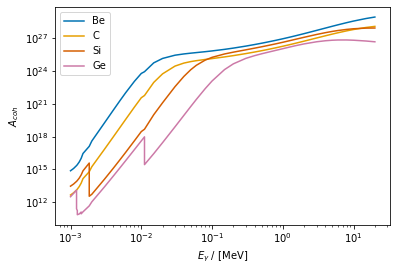

In [6]:
for e in elements:
    plt.plot(photon_energies, coherent_nucleons[e](photon_energies), label=e)
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$E_\gamma$ / [MeV]")
plt.ylabel(r"$A_{coh}$")
plt.legend()

In [7]:
# Debye-Waller factor
debye_waller_factors = {}
for e in elements:
    deb = debye_temperatures[e]
    M = molar_masses[e] * (u.mol / c.Avogadro)  # Mass of a single atom
    T = 293.0 * u.kelvin
    Phi = T / deb * quad(lambda x: x / (np.exp(x) - 1), 0, deb / T)[0]
    A = (
        (3.0 / 4.0)
        * ((0.511 * u.MeV / c.c_light_sq) / M)
        * (0.511 * u.MeV / (c.k_Boltzmann * deb))
        * (1 + 4 * (T / deb) * Phi)
    )
    print(e, deb, Phi, A)

    def fact(q, A=A):
        return np.exp(-A * (q / (0.511 * u.MeV / c.c_light)) ** 2)

    debye_waller_factors[e] = fact

Be 1031.0 0.42890470369353095 391.1325280606361
C 1550.0 0.3049374455485468 161.41510370291266
Si 692.0 0.556597576105063 244.6169220813976
Ge 403.0 0.707730013301325 253.62367781649752


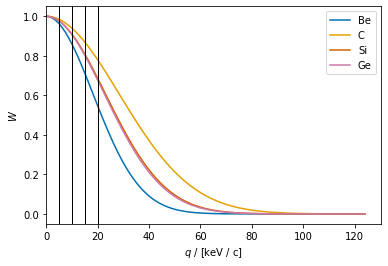

In [8]:
for e in elements:
    plt.plot(
        transfered_momenta / (u.keV / c.c_light),
        debye_waller_factors[e](transfered_momenta),
        label=e,
    )

plt.axvline(5, color="k", linewidth=1)
plt.axvline(10, color="k", linewidth=1)
plt.axvline(15, color="k", linewidth=1)
plt.axvline(20, color="k", linewidth=1)
# plt.yscale("log")
plt.xlabel(r"$q$ / [keV / c]")
plt.ylabel(r"$W$")
plt.xlim(0)
plt.legend()

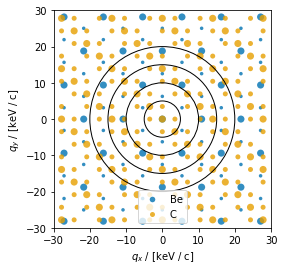

In [9]:
for e, (b1, b2, b3) in reciprocal_lattice_vectors.items():
    sf = structure_factors[e]
    N = cell_occupancies[e]
    points = []
    factors = []
    for h in range(-10, 10):
        for k in range(-10, 10):
            l = 0
            points.append(b1 * h + b2 * k + b3 * l)
            factors.append(sf(h, k, l) / N)

    points = np.array(points) * c.hbar / (u.keV / c.c_light)
    factors = np.array(factors)
    plt.scatter(points[:, 0], points[:, 1], s=(factors) ** 2 * 50, linewidth=0, alpha=0.8, label=e)

plt.gca().add_patch(plt.Circle((0, 0), 5, fill=False))
plt.gca().add_patch(plt.Circle((0, 0), 10, fill=False))
plt.gca().add_patch(plt.Circle((0, 0), 15, fill=False))
plt.gca().add_patch(plt.Circle((0, 0), 20, fill=False))

plt.xlabel(r"$q_x$ / [keV / c]")
plt.ylabel(r"$q_y$ / [keV / c]")
plt.gca().set_aspect("equal")
plt.xlim(-30, 30)
plt.ylim(-30, 30)
plt.legend()

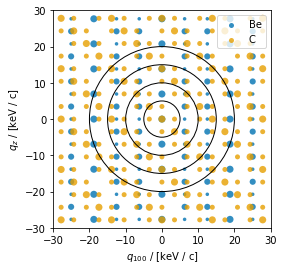

In [10]:
for e, (b1, b2, b3) in reciprocal_lattice_vectors.items():
    sf = structure_factors[e]
    N = cell_occupancies[e]
    points = []
    factors = []
    for h in range(-10, 10):
        for l in range(-10, 10):
            k = 0
            points.append(b1 * h + b2 * k + b3 * l)
            factors.append(sf(h, k, l) / N)

    points = np.array(points) * c.hbar / (u.keV / c.c_light)
    factors = np.array(factors)
    
    x = np.dot(points, b1) / np.linalg.norm(b1)
    
    plt.scatter(x, points[:, 2], s=(factors) ** 2 * 50, linewidth=0, alpha=0.8, label=e)

plt.gca().add_patch(plt.Circle((0, 0), 5, fill=False))
plt.gca().add_patch(plt.Circle((0, 0), 10, fill=False))
plt.gca().add_patch(plt.Circle((0, 0), 15, fill=False))
plt.gca().add_patch(plt.Circle((0, 0), 20, fill=False))

plt.xlabel(r"$q_{100}$ / [keV / c]")
plt.ylabel(r"$q_z$ / [keV / c]")
plt.gca().set_aspect("equal")
plt.xlim(-30, 30)
plt.ylim(-30, 30)
plt.legend()

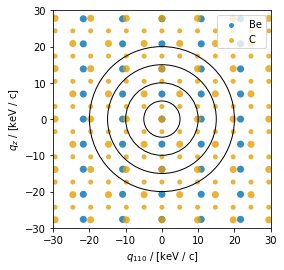

In [11]:
for e, (b1, b2, b3) in reciprocal_lattice_vectors.items():
    sf = structure_factors[e]
    N = cell_occupancies[e]
    points = []
    factors = []
    for h in range(-10, 10):
        for l in range(-10, 10):
            k = h
            points.append(b1 * h + b2 * k + b3 * l)
            factors.append(sf(h, k, l) / N)

    points = np.array(points) * c.hbar / (u.keV / c.c_light)
    factors = np.array(factors)
    
    x = np.dot(points, b1 + b2) / np.linalg.norm(b1 + b2)
    
    plt.scatter(x, points[:, 2], s=(factors) ** 2 * 50, linewidth=0, alpha=0.8, label=e)

plt.gca().add_patch(plt.Circle((0, 0), 5, fill=False))
plt.gca().add_patch(plt.Circle((0, 0), 10, fill=False))
plt.gca().add_patch(plt.Circle((0, 0), 15, fill=False))
plt.gca().add_patch(plt.Circle((0, 0), 20, fill=False))

plt.xlabel(r"$q_{110}$ / [keV / c]")
plt.ylabel(r"$q_z$ / [keV / c]")
plt.gca().set_aspect("equal")
plt.xlim(-30, 30)
plt.ylim(-30, 30)
plt.legend()

In [12]:
# xsec increasing factors
# sigma_crystal(q) propto (f(q) * sum_i^N exp(i phi_i))**2 = (f(q) * N_cell * sum_j^M exp(i phi_j) delta(q, hkl))**2
#   = N_cell**2 * F_hkl(q)**2 f(q)**2
# sigma
# sigma_crystal / nucleon = A_coherent * sum_q DWF(q)

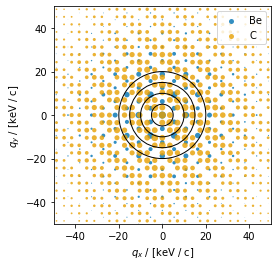

In [13]:
for e, (b1, b2, b3) in reciprocal_lattice_vectors.items():
    sf = structure_factors[e]
    N = cell_occupancies[e]
    dwf = debye_waller_factors[e]
    points = []
    factors = []
    for h in range(-100, 100):
        for k in range(-100, 100):
            l = 0
            q = (b1 * h + b2 * k + b3 * l) * c.hbar
            points.append(q)
            factors.append(sf(h, k, l) / N * dwf(np.linalg.norm(q)))

    points = np.array(points) / (u.keV / c.c_light)
    factors = np.array(factors)
    
    plt.scatter(points[:, 0], points[:, 1], s=factors * 50, linewidth=0, alpha=0.8, label=e)

plt.gca().add_patch(plt.Circle((0, 0), 5, fill=False))
plt.gca().add_patch(plt.Circle((0, 0), 10, fill=False))
plt.gca().add_patch(plt.Circle((0, 0), 15, fill=False))
plt.gca().add_patch(plt.Circle((0, 0), 20, fill=False))

plt.xlabel(r"$q_x$ / [keV / c]")
plt.ylabel(r"$q_y$ / [keV / c]")
plt.gca().set_aspect("equal")
plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.legend()

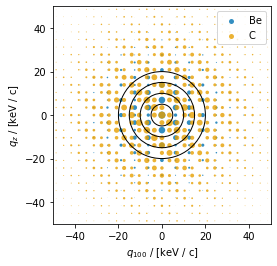

In [14]:
for e, (b1, b2, b3) in reciprocal_lattice_vectors.items():
    sf = structure_factors[e]
    N = cell_occupancies[e]
    dwf = debye_waller_factors[e]
    points = []
    factors = []
    for h in range(-100, 100):
        for l in range(-100, 100):
            k = 0
            q = (b1 * h + b2 * k + b3 * l) * c.hbar
            points.append(q)
            factors.append(sf(h, k, l) / N * dwf(np.linalg.norm(q)))

    points = np.array(points) / (u.keV / c.c_light)
    factors = np.array(factors)
    
    x = np.dot(points, b1) / np.linalg.norm(b1)
    
    plt.scatter(x, points[:, 2], s=(factors) ** 2 * 50, linewidth=0, alpha=0.8, label=e)

plt.gca().add_patch(plt.Circle((0, 0), 5, fill=False))
plt.gca().add_patch(plt.Circle((0, 0), 10, fill=False))
plt.gca().add_patch(plt.Circle((0, 0), 15, fill=False))
plt.gca().add_patch(plt.Circle((0, 0), 20, fill=False))

plt.xlabel(r"$q_{100}$ / [keV / c]")
plt.ylabel(r"$q_z$ / [keV / c]")
plt.gca().set_aspect("equal")
plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.legend()

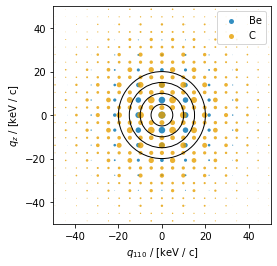

In [15]:
for e, (b1, b2, b3) in reciprocal_lattice_vectors.items():
    sf = structure_factors[e]
    N = cell_occupancies[e]
    dwf = debye_waller_factors[e]
    points = []
    factors = []
    for h in range(-100, 100):
        for l in range(-100, 100):
            k = h
            q = (b1 * h + b2 * k + b3 * l) * c.hbar
            points.append(q)
            factors.append(sf(h, k, l) / N * dwf(np.linalg.norm(q)))

    points = np.array(points) / (u.keV / c.c_light)
    factors = np.array(factors)
    
    x = np.dot(points, b1 + b2) / np.linalg.norm(b1 + b2)
    
    plt.scatter(x, points[:, 2], s=(factors) ** 2 * 50, linewidth=0, alpha=0.8, label=e)

plt.gca().add_patch(plt.Circle((0, 0), 5, fill=False))
plt.gca().add_patch(plt.Circle((0, 0), 10, fill=False))
plt.gca().add_patch(plt.Circle((0, 0), 15, fill=False))
plt.gca().add_patch(plt.Circle((0, 0), 20, fill=False))

plt.xlabel(r"$q_{110}$ / [keV / c]")
plt.ylabel(r"$q_z$ / [keV / c]")
plt.gca().set_aspect("equal")
plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.legend()

Be	32.38173680357632
C	121.43123777482306


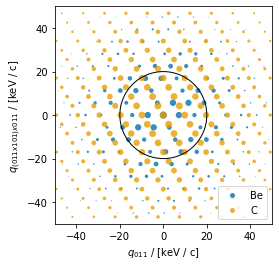

In [16]:
for e, (b1, b2, b3) in reciprocal_lattice_vectors.items():
    a1, a2, a3 = lattice_vectors[e]
    sf = structure_factors[e]
    N = cell_occupancies[e]
    dwf = debye_waller_factors[e]
    points = []
    factors = []
    for i in range(-100, 100):
        for j in range(-100, 100):
            h = i
            k = j
            l = i + j
            q = (b1 * h + b2 * k + b3 * l) * c.hbar
            points.append(q)
            factors.append(sf(h, k, l) / N * dwf(np.linalg.norm(q)))

    points = np.array(points) / (u.keV / c.c_light)
    factors = np.array(factors)
    # crystal_xsec = sum_q nucleon_xsec * A_crystal * A_coherent
    factor_sum = np.sum(factors)
    print(e, factor_sum, sep="\t")
    
    e1 = b2 + b3
    x = np.dot(points, e1) / np.linalg.norm(e1)
    e2 = np.cross(np.cross(e1, b1 + b3), e1)
    y = np.dot(points, e2) / np.linalg.norm(e2)
    
    plt.scatter(x, y, s=factors * 50, linewidth=0, alpha=0.8, label=e)

#plt.gca().add_patch(plt.Circle((0, 0), 5, fill=False))
#plt.gca().add_patch(plt.Circle((0, 0), 10, fill=False))
#plt.gca().add_patch(plt.Circle((0, 0), 15, fill=False))
plt.gca().add_patch(plt.Circle((0, 0), 20, fill=False))

plt.xlabel(r"$q_{011}$ / [keV / c]")
plt.ylabel(r"$q_{(011x101)x011}$ / [keV / c]")
plt.gca().set_aspect("equal")
plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.legend(loc="lower right")